In [ ]:
! nvidia-smi

Wed May  5 06:35:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convert to csv (do not run)

In [ ]:
import re

train_path = "/content/drive/MyDrive/NER/dataset/train.txt"
test_path = "/content/drive/MyDrive/NER/dataset/test.txt"

def process(content):
  if '"' in content:
    content = content.replace('"', '""""')
  if "'" in content:
    content = content.replace('"', '""""')
  index = content.find("\t")
  if "," in content:
    content = '"' + content[:index] + '"' + content[index:]
  content = content.replace('\t', ",")
  content = content.replace('\n', ",")
  return content

with open(test_path, "r") as f:
  contents = f.readlines()

string_insert = "\n"
contents.insert(0, string_insert)

num_sentence = 1

for i, content in enumerate(contents):
  if content == "\n":
    continue
  else:
    if contents[i-1] == "\n":
      content = process(content)
      sentence = "Sentence: " + str(num_sentence)
      num_sentence += 1
      contents[i] = sentence + ',' + content
    else:
      content = process(content)
      contents[i] = "NaN," + content

contents = [content for content in contents if "\n" not in content]

header = "Sentence #,Word,Tag"
contents.insert(0, header)
csv = "\n".join(contents)

In [ ]:
pattern = re.compile("[+-/$]*([0-9]*\.*[0-9]*,)*[0-9]+([-/][0-9]+,[0-9]+)*")
pattern.search("10/10/2017")

<re.Match object; span=(0, 2), match='10'>

In [ ]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import pandas as pd

TESTDATA = StringIO(csv)

data = pd.read_csv(TESTDATA, sep=",", index_col=False, encoding='unicode_escape')
data = data[data['Word'].notna()]
# saving the dataframe
data.to_csv(r'/content/drive/MyDrive/NER/dataset/ner_vcc_test.csv', index=False, encoding="utf-8-sig")
data[:30]

,Sentence #,Word,Tag
0,Sentence: 1,Trong,O
1,NaN,năm,B-TIM
2,NaN,2019,I-TIM
3,NaN,",",O
4,NaN,có,O
5,NaN,khoảng,O
6,NaN,71.552,O
7,NaN,chiếc,B-PRO
8,NaN,Honda_Avancier,I-PRO
9,NaN,và,O


In [ ]:
# check for NA values
for i, y in enumerate(data.Word):
    if pd.isnull(y):
      print(i)

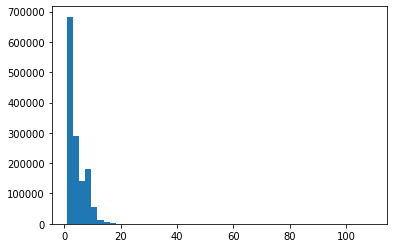

In [ ]:
from matplotlib import pyplot as plt
plt.hist([len(sen) for sen in data.Word], bins=50)
plt.show()

# Define data loader and model

In [ ]:
!pip install vncorenlp

     |████████████████████████████████| 2.7MB 10.5MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645936 sha256=3cac5856ae19e3272c0749a1e01bc7475e93bf2d7a1fea71e6018f44dbff5e64
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp


In [ ]:
!ls /content/drive/MyDrive/NER/VnCoreNLP-1.1.1/

LICENSE.md  Readme.md		  VLSP2013_POS_tagset.pdf
models	    src			  VnCoreNLP-1.1.1.jar
pom.xml     TagsetDescription.md  VnDT-treebank-description.pdf


In [ ]:
VNCORENLP_PATH = "/content/drive/MyDrive/NER/VnCoreNLP-1.1.1/VnCoreNLP-1.1.1.jar"
from vncorenlp import VnCoreNLP

segmenter = VnCoreNLP(VNCORENLP_PATH, annotators="wseg", max_heap_size='-Xmx500m') 

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 10.3MB/s 
     |████████████████████████████████| 901kB 42.0MB/s 
     |████████████████████████████████| 3.3MB 37.8MB/s 


In [ ]:
import torch

class EntityDataset:
    def __init__(self, texts, tags):
        self.texts = texts
        self.tags = tags
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        tags = self.tags[item]

        ids = []
        target_tag = []

        for i, s in enumerate(text):
            inputs = TOKENIZER.encode(s, add_special_tokens=False)
            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend([tags[i]] * input_len)

        ids = ids[:MAX_LEN - 2]
        target_tag = target_tag[:MAX_LEN - 2]

        ids = [0] + ids + [2] # <s>: 0, </s>: 2, <pad>: 1
        target_tag = [12] + target_tag + [12] # O: 12

        mask = [1] * len(ids) # 1: not masked, 0: masked
        token_type_ids = [0] * len(ids)

        padding_len = MAX_LEN - len(ids)

        ids = ids + ([1] * padding_len) # padding
        mask = mask + ([0] * padding_len) # 1: not masked, 0: masked
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tag = target_tag + ([12] * padding_len) # O: 12

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }

def loss_fn(output, target, mask, num_labels):
    lfn = torch.nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss

class EntityModel(torch.nn.Module):
    def __init__(self, num_tag):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH,return_dict=False)
        self.bert_drop = torch.nn.Dropout(0.3)
        self.out_tag = torch.nn.Linear(768, self.num_tag)
    
    def forward(self, ids, mask, token_type_ids, target_tag):
        o, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo_tag = self.bert_drop(o)
        tag = self.out_tag(bo_tag)
        loss = loss_fn(tag, target_tag, mask, self.num_tag)
        return tag, loss

In [ ]:
import transformers

MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 10
BASE_MODEL_PATH = "vinai/phobert-base"
MODEL_PATH = "/content/drive/MyDrive/NER/unfreeze_model.bin"
TRAINING_FILE = "/content/drive/MyDrive/NER/dataset/ner_vcc_train.csv"
TESTING_FILE = "/content/drive/MyDrive/NER/dataset/ner_vcc_test.csv"
TOKENIZER = transformers.AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
import joblib
from vncorenlp import VnCoreNLP

def process_data(data_path):
    df = pd.read_csv(data_path, encoding="utf-8")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_tag = preprocessing.LabelEncoder()
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, tag, enc_tag

if __name__ == "__main__":

    meta_data = joblib.load("/content/drive/MyDrive/NER/meta.bin")
    enc_tag = meta_data["enc_tag"]

    num_tag = len(list(enc_tag.classes_))

    device = torch.device("cuda")
    model = EntityModel(num_tag=num_tag)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(device)

# Test testing data

In [ ]:
import pandas as pd
from sklearn import preprocessing

print("Encoded tag for training data: {}".format(enc_tag.classes_))

sentences, tag, enc_tag_test = process_data(TESTING_FILE)
# make sure encoded tag are common in both training and testing dataset
print("Encoded tag for testing data: {}".format(enc_tag_test.classes_))

Encoded tag for training data: ['B-EVE' 'B-LOC' 'B-ORG' 'B-PER' 'B-PRO' 'B-TIM' 'I-EVE' 'I-LOC' 'I-ORG'
 'I-PER' 'I-PRO' 'I-TIM' 'O']
Encoded tag for testing data: ['B-EVE' 'B-LOC' 'B-ORG' 'B-PER' 'B-PRO' 'B-TIM' 'I-EVE' 'I-LOC' 'I-ORG'
 'I-PER' 'I-PRO' 'I-TIM' 'O']


In [ ]:
sentences

array([list(['Yuval_Noah_Harari', 'nhận', 'bằng', 'Tiến_sĩ', 'của', 'Đại_học', 'Oxford', 'năm', '2002', ',', 'là', 'giảng_viên', 'Khoa', 'Lịch_sử', ',', 'Đại_học', 'Hebrew', 'ở', 'Jerusalem', '.']),
       list(['Ngoài', 'việc', 'phân_tích', 'sai_lầm', 'của', 'nhà_cầm_quân', '44', 'tuổi', 'khi', 'dẫn_dắt', 'Port', 'FC', 'thì', 'tờ', 'này', 'cũng', 'khuyên', '"', 'Zico_Thái', '"', 'nên', 'cân_nhắc', 'việc', 'ngồi', 'lên', '"', 'ghế', 'nóng', '"', 'của', 'ĐT', 'Việt_Nam', 'nếu', 'được', 'LĐBĐ', 'Việt_Nam', '(', 'VFF', ')', 'đề_nghị', '.']),
       list(['Ông', 'Đặng_Trịch', '(', 'thôn', 'Lệ_Sơn', '2', ')', 'cho_biết', ':', '"', 'Mặt_đường', 'lầy_lội', ',', 'nhiều', 'ổ_gà', 'làm', 'học_sinh', 'đi', 'xe_đạp', 'bị', 'ngã', '.']),
       ...,
       list(['VKS', 'cũng', 'đề_nghị', 'miễn', 'trách_nhiệm', 'hình_sự', 'cho', ':', 'Nguyễn_Việt_Hà', '-', 'cựu', 'Giám_đốc', 'Chi_nhánh', 'Thái_Bình', ';', 'Nguyễn_Phan_Trung_Kiên', '-', 'cựu', 'Giám_đốc', 'Phòng', 'giao_dịch', 'Đông_Đô', ';', 'Nguyễn

In [ ]:
test_dataset = EntityDataset(texts=sentences, tags=tag)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(test_dataset)

8042

In [ ]:
pred_tag = []
with torch.no_grad():
  for data in test_dataset:
    for k, v in data.items():
      data[k] = v.to(device).unsqueeze(0)
    tag, _ = model(**data)
    pred_tag.append(tag)

predict_tag = []
for tag, sentence in zip(pred_tag, sentences):
  tags = enc_tag.inverse_transform(tag.argmax(2).cpu().numpy().reshape(-1))[:len(sentence) + 2]
  predict_tag.append(tags)

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
  for data in test_dataset:
    for k, v in data.items():
      print(data)
      data[k] = v.to(device).unsqueeze(0)
      print(data)

ValueError: ignored

In [ ]:
target_tag = []

for dataset, sentence in zip(test_dataset, sentences):
  tag = dataset['target_tag'][:len(sentence) + 2]
  tag = enc_tag.inverse_transform(tag)
  target_tag.append(tag)

In [ ]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 9.7MB/s 


In [ ]:
from sklearn_crfsuite import metrics

print(metrics.flat_classification_report(target_tag, predict_tag, labels=enc_tag.classes_[:-1], digits=3))

              precision    recall  f1-score   support

       B-EVE      0.891     0.880     0.885      2792
       B-LOC      0.960     0.952     0.956     10879
       B-ORG      0.917     0.948     0.932      9487
       B-PER      0.980     0.979     0.980     15809
       B-PRO      0.874     0.860     0.867      4674
       B-TIM      0.979     0.983     0.981      5169
       I-EVE      0.957     0.784     0.861      5921
       I-LOC      0.950     0.912     0.930      6179
       I-ORG      0.929     0.942     0.936      9853
       I-PER      0.921     0.911     0.916      1344
       I-PRO      0.860     0.906     0.882      7169
       I-TIM      0.991     0.971     0.981      5501

   micro avg      0.941     0.932     0.936     84777
   macro avg      0.934     0.919     0.926     84777
weighted avg      0.942     0.932     0.936     84777



# Test one sample

In [ ]:
sentence = "Yuval Noah Harari nhận bằng Tiến sĩ của Đại học Oxford năm 2002, hiện là giảng viên Khoa lịch sử, Đại học Hebrew ở Jerusalem."
segmented_sentence = segmenter.tokenize(sentence)

test_dataset = EntityDataset(texts=[segmented_sentence[0]], tags=[[0] * len(segmented_sentence[0])])

tags = []
with torch.no_grad():
  data = test_dataset[0]
  for k, v in data.items():
    data[k] = v.to(device).unsqueeze(0)
  tag, _ = model(**data)

decoded_sentence = []
for tokenized_word in test_dataset[0]["ids"]:
  decoded_word = TOKENIZER.decode([tokenized_word])
  decoded_sentence.append(decoded_word)

tags = enc_tag.inverse_transform(tag.argmax(2).cpu().numpy().reshape(-1))[:len(decoded_sentence)]

print("{:15} {:5}".format("Word", "Tag"))
print("="*30)
for w, t in zip(decoded_sentence, tags):
  if w == "<pad>": break
  print("{:15}:{:5}".format(w, t))

Word            Tag  
<s>            :O    
Yu@@           :B-PER
v@@            :B-PER
al_@@          :B-PER
No@@           :B-PER
ah_@@          :B-PER
Har@@          :B-PER
ari            :B-PER
nhận           :O    
bằng           :O    
Tiến_sĩ        :O    
của            :O    
Đại_học        :B-ORG
Oxford         :I-ORG
năm            :B-TIM
2002           :I-TIM
,              :O    
hiện           :O    
là             :O    
giảng_viên     :O    
Khoa           :O    
lịch_sử        :O    
,              :O    
Đại_học        :B-ORG
Heb@@          :I-ORG
re@@           :I-ORG
w              :I-ORG
ở              :O    
Jerusalem      :B-LOC
.              :O    
</s>           :O    
